# Create a dataset using alpha vantage

In [109]:
try:
    import alpha_vantage
except:
    ! pip install alpha_vantage
    import alpha_vantage

import requests
from pprint import pprint
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import json
import time
from tqdm import tqdm
import os
sns.set()
pd.set_option('display.max_colwidth',1000)

## get all tickers from alpha vantange api

In [192]:
def get_symbols(start_date=0, end_date=0):
    # API KEY: NG88F4E3M06AUO7C
    # API KEY: API_KEY
    # API KEY: 9XZQZQZQZQZQZQZQ
    # API KEY: demo
    CSV_URL = 'https://www.alphavantage.co/query?function=LISTING_STATUS&apikey=NG88F4E3M06AUO7C'
    return pd.read_csv(CSV_URL)

tickers = get_symbols()

### Do some pre-processing on the dataset to make it a bit more presentable

In [193]:
# set the index of the dataframe to the ticker symbol
tickers.set_index('symbol', inplace=True)
# sort the dataframe according to the date
tickers.sort_values('ipoDate', inplace=True)
# remove lines where delistingDate is not null
tickers = tickers[tickers['delistingDate'].isnull() & tickers['status'].str.contains('Active')]
# remove the delistingDate column
tickers.drop('delistingDate', axis=1, inplace=True)
# remove the status column
tickers.drop('status', axis=1, inplace=True)
# find any duplicates in the name column and remove the earliest ones from the dataframe
tickers.drop_duplicates(subset='name', keep='last', inplace=True)
# convert ipoDate to datetime and parse out the year of the IPO from the ipoDate column
tickers['ipoDate'] = pd.to_datetime(tickers['ipoDate'])
tickers['ipoYear'] = tickers['ipoDate'].dt.year
print(tickers.describe(include=['object']))
tickers.head()

                            name exchange assetType
count                      11114    11115     11115
unique                     11114        5         2
top     General Electric Company   NASDAQ     Stock
freq                           1     5313      7715


,name,exchange,assetType,ipoDate,ipoYear
symbol,,,,,
GE,General Electric Company,NYSE,Stock,1962-01-02,1962
CAT,Caterpillar Inc,NYSE,Stock,1962-01-02,1962
KO,Coca-Cola Company,NYSE,Stock,1962-01-02,1962
BA,Boeing Company,NYSE,Stock,1962-01-02,1962
IBM,International Business Machines Corp,NYSE,Stock,1962-01-02,1962


In [194]:
# locate the row containing the symbol aapl
pprint(tickers.loc['AAPL'])

name                   Apple Inc
exchange                  NASDAQ
assetType                  Stock
ipoDate      1980-12-12 00:00:00
ipoYear                     1980
Name: AAPL, dtype: object


### Plot the histogram with the number of ipos in the x axis

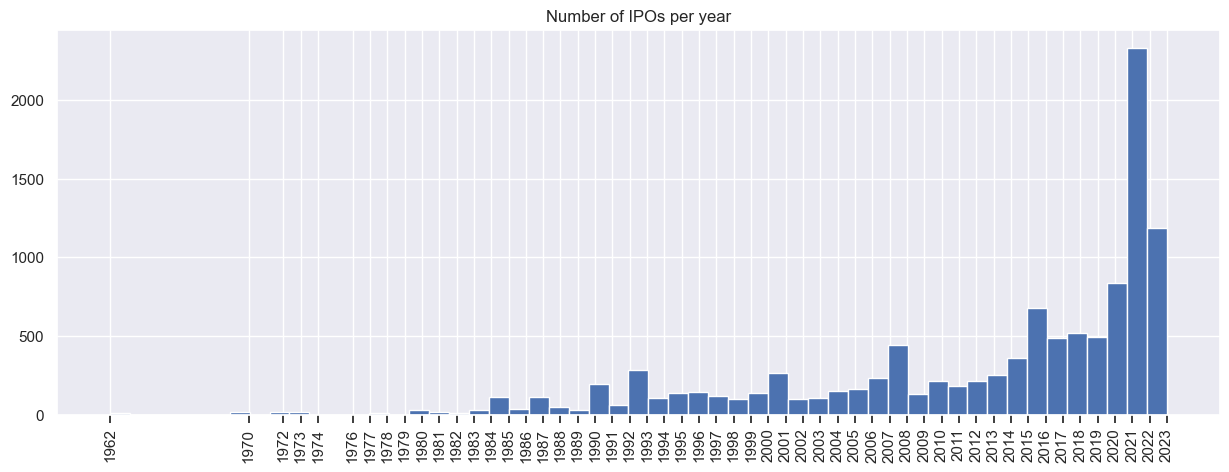

In [195]:
# get the number of unique values in the ipoYear column
years = tickers['ipoYear'].nunique()
# plot a histogram of the number of IPOs per year and show all the years on the x-axis
tickers['ipoYear'].hist(bins=years, xrot=90, figsize=(15, 5), align='mid')
plt.title('Number of IPOs per year')
plt.xticks(tickers['ipoYear'].unique())
# move all x ticks to the left
plt.gca().xaxis.tick_bottom()
plt.show()

In [87]:
# save the dataframe to a csv file
tickers.to_csv('tickers.csv')

## Build the news sentiments dataset

In [175]:
def get_sentiments(company_symbol: str = '', news_topic: str = '', time_from: str = '', time_to: str = '', sort_by: str = 'RELEVANCE'):
    keys = ['API_KEY', 'YOUR_API_KEY', '9XZQZQZQZQZQZQZQ', 'TQ82I6FBRGST0SWG', 'NG88F4E3M06AUO7C', 'BVLIQRCET4I22OM8', '55AYQEHU4F19W8YS', '2AUO2G9N2BT4FMT6']
    # API KEY: NG88F4E3M06AUO7C
    # API KEY: BVLIQRCET4I22OM8
    # API KEY: 55AYQEHU4F19W8YS
    endpoint = "https://www.alphavantage.co/query"
    for key in keys:
        parameters = {
            "function": "NEWS_SENTIMENT",
            "sort": sort_by,
            "limit": "200",
            "apikey": key,
        }
        if time_from and time_to: parameters['time_from'] = time_from; parameters['time_to'] = time_to
        if news_topic: parameters['topics'] = news_topic
        if company_symbol: parameters['tickers'] = company_symbol
        # Send a GET request to the API endpoint
        response = requests.get(endpoint, params=parameters)
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            if 'Note' in data: print('api overuse'); continue
            return data
        else: print(response)

# pprint(get_sentiments())

### Download all news sentiments from the past 100 days
Create a dataframe of the sentiments grouped by ticker symbols and sorted by time

Note that the sentiment score values indicate:
* Bearish: x <= -0.35
* Somewhat-Bearish: -0.35 < x <= -0.15
* Neutral: -0.15 < x < 0.15
* Somewhat_Bullish: 0.15 <= x < 0.35 
* Bullish: x >= 0.35


Note that another value maintained is the relevance score indicating the relevance of each article to the ticker 0 < x <= 1, with a higher score indicating higher relevance. However, this value is ignored for now. 

In [187]:
ordered_sentiments = []
for news in tqdm(all_news):
    # temp addition
    if 'Note' in news: continue
    for article in news['feed']:
        # parse date time from YYYYMMDDTHHMM format to datetime object
        time_pub = datetime.strptime(article['time_published'], '%Y%m%dT%H%M%S')
        ordered_sentiments.append({'ticker': None, 'sentiment': article['overall_sentiment_score'], 'time': time_pub, 'url': article['url']})
        for tickers_sents in article['ticker_sentiment']:
            ordered_sentiments.append({'ticker': tickers_sents['ticker'], 'sentiment': tickers_sents['ticker_sentiment_score'], 'time': time_pub, 'url': article['url']})

100%|██████████| 5/5 [00:00<00:00, 384.21it/s]


In [199]:
# create a dataframe from the list of dictionaries
# remove duplicates caused by the same article being published on multiple websites or downloading multiple times using the sort_by
sent_df = pd.DataFrame(ordered_sentiments).drop_duplicates(keep='last').sort_values(by='time', ascending=False).set_index('ticker')
start_time, end_time = sent_df.iloc[0]['time'].strftime('%d_%m_%Y'), sent_df.iloc[-1]['time'].strftime('%d_%m_%Y')
# save the dataframe to a csv file
sent_df.to_csv(f'sentiments_{start_time}_{end_time}.csv')
sent_df.head()

,sentiment,time,url
ticker,,,
WATT,0.0,2023-02-01 23:05:06,https://www.zacks.com/stock/news/2048011/regal-beloit-rrx-q4-earnings-top-estimates
NaN,0.165205,2023-02-01 23:05:06,https://www.zacks.com/stock/news/2048011/regal-beloit-rrx-q4-earnings-top-estimates
NaN,0.31073,2023-02-01 23:05:00,https://www.prnewswire.com/news-releases/kinderhook-sells-vesta-modular-to-mcgrath-rentcorp-301736750.html
HCSG,0.098966,2023-02-01 23:05:00,https://www.prnewswire.com/news-releases/kinderhook-sells-vesta-modular-to-mcgrath-rentcorp-301736750.html
MGRC,0.165244,2023-02-01 23:05:00,https://www.prnewswire.com/news-releases/kinderhook-sells-vesta-modular-to-mcgrath-rentcorp-301736750.html


In [227]:
# load the csv file into a dataframe
sent_df = pd.read_csv('sentiments_30_01_2023_12_04_2022.csv')
print(sent_df.head(5))
# use pandas describe to show statistics of the string columns
sent_df.describe(include=['object'])

  ticker  sentiment                 time  \
0    JXN   0.095073  2023-01-30 23:00:21   
1    NaN   0.172666  2023-01-30 23:00:21   
2    AMN   0.160080  2023-01-30 23:00:21   
3    NaN   0.103864  2023-01-30 23:00:21   
4      M   0.116960  2023-01-30 23:00:21   

                                                                                                                  url  
0  https://www.zacks.com/stock/news/2046606/jackson-financial-jxn-dips-more-than-broader-markets-what-you-should-know  
1                          https://www.zacks.com/stock/news/2046609/macys-m-gains-as-market-dips-what-you-should-know  
2          https://www.zacks.com/stock/news/2046607/amn-healthcare-services-amn-stock-moves--088-what-you-should-know  
3          https://www.zacks.com/stock/news/2046607/amn-healthcare-services-amn-stock-moves--088-what-you-should-know  
4                          https://www.zacks.com/stock/news/2046609/macys-m-gains-as-market-dips-what-you-should-know  


,ticker,time,url
count,15648,23763,23763
unique,3348,5571,8111
top,TSLA,2023-01-29 12:17:00,https://www.cnn.com/2023/01/29/investing/stocks-week-ahead
freq,316,86,43


# TODO ADD SOME VISULAZIATIONS OF THE DATASET HERE

            sentiment  time  url
ticker                          
TSLA              316   316  316
CRYPTO:BTC        296   296  296
FOREX:USD         284   284  284
META              233   233  233
GOOG              229   229  229
GS                214   214  214
AWON              195   195  195
CRYPTO:ETH        191   191  191
MSFT              186   186  186
MS                174   174  174


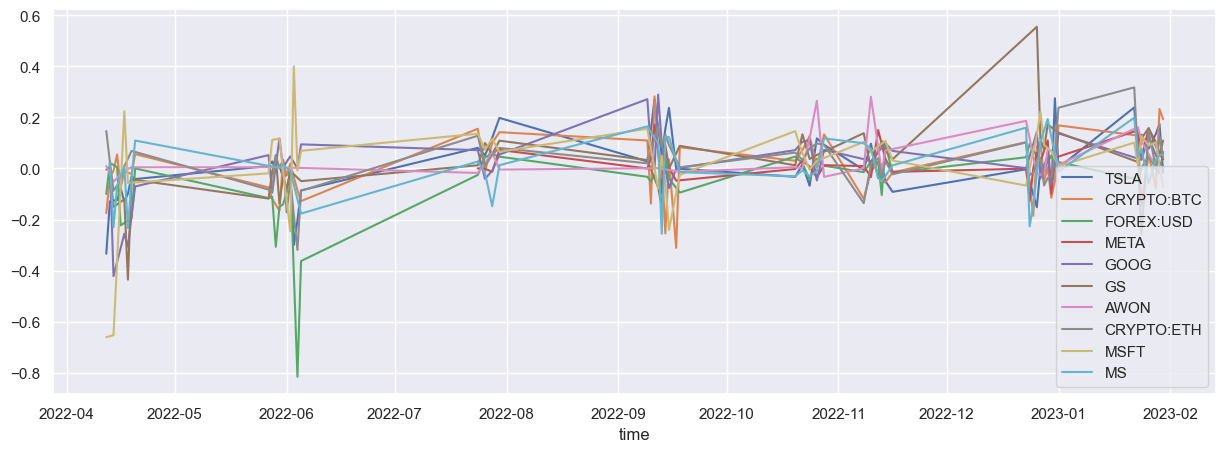

In [240]:
# group the dataframe by day
sent_df['time'] = pd.to_datetime(sent_df['time']).dt.date
# sort by maximum frequency of tickers and get a list of the top 20 most frequent tickers
top_10_tickers = sent_df.groupby('ticker').count().sort_values(by='time', ascending=False).head(10).index
# print(sent_df.groupby('ticker').count().sort_values(by='time', ascending=False).head(10))
# for a list of indices, plot the sentiment score for each ticker
for ticker in top_10_tickers:
    sent_df[sent_df['ticker'] == ticker].groupby('time').mean()['sentiment'].plot(figsize=(15, 5), label=ticker)

plt.legend()
